This is a notebook to visualise code 'gradual_ascent.py' and help analyse the result

In [1]:
from headers import *

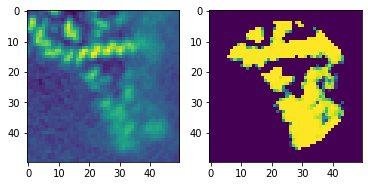

In [2]:
slice_index = 12
map_2d = get_slice('test_map.mrc',slice_index)
mask_2d = get_slice('test_mask.mrc',slice_index)
plt.subplot(1,2,1)
plt.imshow(map_2d);
plt.subplot(1,2,2)
plt.imshow(mask_2d);

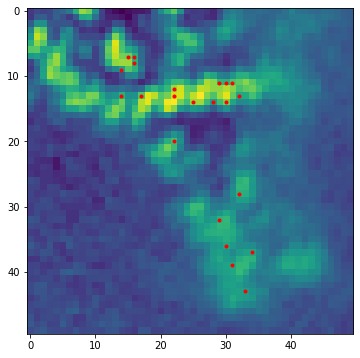

In [34]:
# Find all indices inside mask
all_inside_mask = np.asarray(np.where(mask_2d==1)).T.tolist()
# 10% of all points inside mask are to be selected at random 
num_points = int(len(all_inside_mask) * 0.1)
# all points are defined as a PointClass object (definition can be seen in headers.py)
points = [PointClass(tuple([x[1],x[0]])) for x in random.sample(all_inside_mask,num_points)]
temp = points.copy()
plt.figure(figsize=(6,6))
plot_current_positions_and_map(map_2d,points,'r')

Now run the main solver and change the parameters to analyse the behaviour

Text(0.5, 1.0, 'Total map value at each location')

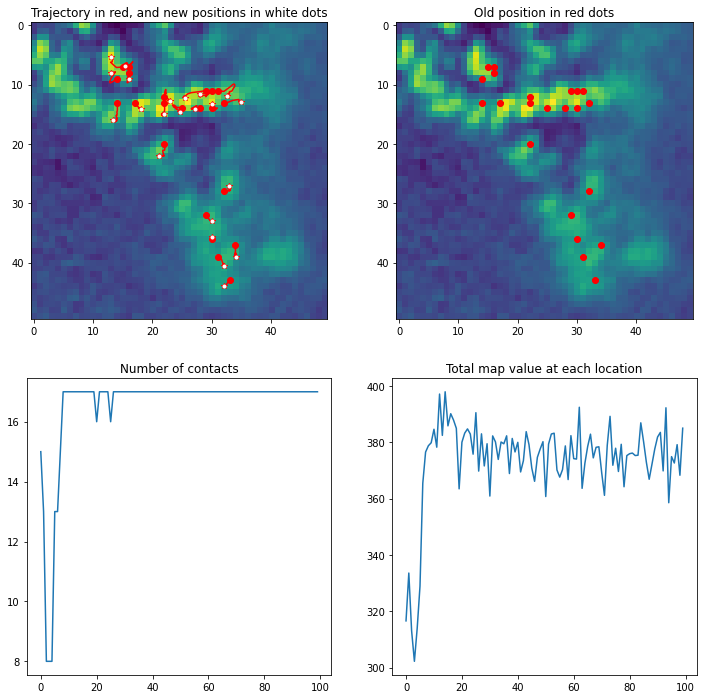

In [57]:
friction = 10
total_iterations = 100
dt = 0.05
scale_lj = 1
scale_map = 1
min_dist = 3
g = 10
capmagnitude_map = 100
capmagnitude_lj = 400
    
(new_points,num_contacts_iterations,map_value_iterations) = main_solver(map_2d,points,friction=friction,total_iterations=total_iterations,dt=dt,g=g,min_dist=min_dist,scale_lj=scale_lj,scale_map=scale_map,capmagnitude_lj=capmagnitude_lj,capmagnitude_map=capmagnitude_map, return_contacts=True,return_map_value=True,return_type='pointclass')
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plot_position_history_and_map(map_2d, new_points,'r')
plot_current_positions_and_map(map_2d, new_points,'w')
plt.title('Trajectory in red, and new positions in white dots')
plt.subplot(2,2,2)
plot_position_history_and_map(map_2d, points,'r')
plt.title('Old position in red dots')
plt.subplot(2,2,3)
plt.plot(num_contacts_iterations)
plt.title('Number of contacts')
plt.subplot(2,2,4)
plt.plot(map_value_iterations)  
plt.title('Total map value at each location')

If you observe, the "number of contacts" have not become zero, but have worsened a bit. But this is not because more atoms have come very close to each other. It's just a result of using two forces (in this case, map gradient and LJ potential) which sometime oppose each other. The atoms are indeed pushed apart from the LJ potential, but they sort of stay near the edge of the boundary of each others. A histogram plot showing the nearest distances for every atom position before and after gives a clear idea. 

The old histogram is in red, while the new (after all the iterations) is in green. 

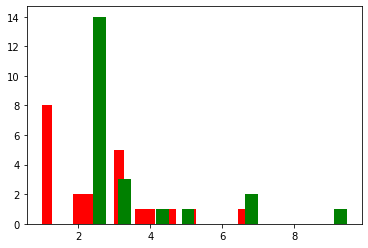

In [54]:
nn_old = get_nearest_neighbor_distance(points)
nn_new = get_nearest_neighbor_distance(new_points)
plt.hist([x for x in nn_old.values()],bins=20,color='r');
plt.hist([x for x in nn_new.values()],bins=20,color='g');

The minimum distance of atoms is indeed pushed away, but not quite at a distance what we want. The new 'minimum distance' is about 1.3-1.4 factor small than the set minimum distance value. This can in principle be solved by increasing the LJ potential scale, but there's a limit to that. Increasing accelerations too much can cause an atom position to fly away from the position. Thus, we can avoid this by introducing a 'lj factor' to the required minimum distance. Basically, we multiply the minimum distance by a factor (1.3-1.5) before calculating the LJ potential. This will ensure that all atoms away from each other by the desired amount. 

In [62]:
(min(nn_old.values()), min(nn_new.values()),min_dist/min(nn_new.values()))

(1.0, 2.4116829328872535, 1.2439446160563141)

Text(0.5, 1.0, 'Total map value at each location')

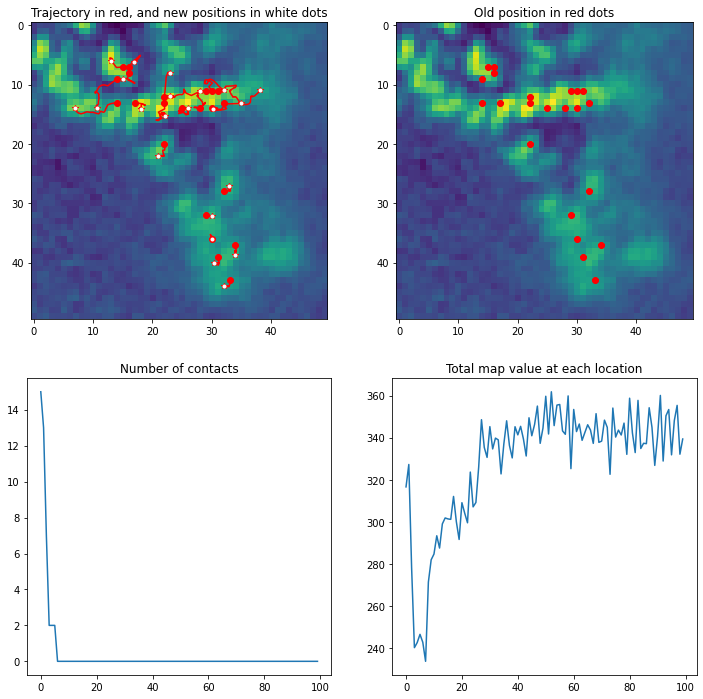

In [64]:

lj_factor = 1.5
    
(new_points,num_contacts_iterations,map_value_iterations) = main_solver(map_2d,points,friction=friction,total_iterations=total_iterations,dt=dt,g=g,min_dist=min_dist,scale_lj=scale_lj,scale_map=scale_map,capmagnitude_lj=capmagnitude_lj,capmagnitude_map=capmagnitude_map, lj_factor=lj_factor,return_contacts=True,return_map_value=True,return_type='pointclass')
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plot_position_history_and_map(map_2d, new_points,'r')
plot_current_positions_and_map(map_2d, new_points,'w')
plt.title('Trajectory in red, and new positions in white dots')
plt.subplot(2,2,2)
plot_position_history_and_map(map_2d, points,'r')
plt.title('Old position in red dots')
plt.subplot(2,2,3)
plt.plot(num_contacts_iterations)
plt.title('Number of contacts')
plt.subplot(2,2,4)
plt.plot(map_value_iterations)  
plt.title('Total map value at each location')

Introducing this LJ factor has an effect of reducing the total map value by a certain amount. 